# Second model for Graph Partitioning in Connected Components

## Problem statement

Let 
* $G = (V,E)$ be an undirected graph, with $V = \{1,\ldots, n\}$ being its node set, and $E \subset \{ \{i,j\}:\, i,j\in V, i \neq j \}$ being its edge set. 
* $ d: E \to \mathbb{R}^{+}$ be a cost function, 
* $k\geq 2$ an integer denoting the fixed number of connected components to partition $G$ into,
* $\alpha \geq 2$ an integer numbers representing the minimum cardinality of each connected component.

A $k$-partition of $V$ is a set $\{V_1,V_2,\ldots,V_k\}$ where $V_i\cap V_j=\emptyset$ for all $i\neq j$, $\bigcup_{c=1}^k V_c=V$, and $V_c \neq \emptyset$ for all $ c \in [k]$, where $[k]$ denotes the set $\{1,\ldots,k\}$. 


The partitioning problem in connected components with minimum size constraints consists of finding a  $k$-partition $\{V_1,V_2,\ldots,V_k\}$ such that each subset $V_c$ induces a connected subgraph, with $|V_c| \geq \alpha$, and the total cost of the edges with end nodes in the same subset of the partition is minimized.


Observe that each connected component of $G$ will have at most $\beta := n-(k-1)\alpha$ nodes. Moreover,  $\alpha$ has to be less than $ \left\lceil \frac{n}{k} \right\rceil$, otherwise the problem is infeasible.

Let us consider the $k$-augmenting graph of $G$, which is the pair $G^k=(V^k, E^k)$, where $V^k=V\cup \mathbb{A}$, $\mathbb{A}=\{n+1,n+2, \ldots, n+k\}$ is a set of artificial nodes (one for each connected component in the partition), $E^k=E\cup E_1$,  and $E_1= \{ \{i,j\}: i \in V, j \in \mathbb{A}\}$.  For each edge $\{i,j\}\in E$, the original cost $d_{ij}$ is retained, while the edges in $E_1$ have a cost set equal to $0$. 

* $y_i^c$ is a binary variable taking the value of one if the node $i \in V$ belongs to $V_c$, for some $c \in [k]$, and zero otherwise;
* $x_{ij}$ takes the value of one if the edge $\{i,j\} \in E$ belongs to any connected component, and zero otherwise;
* $f_{i,j}$ is a continuous variable representing the flow over the arc $(i,j)$. 

Here each edge $\{i,j\}$ has two associated antiparallel arcs, namely $(i,j)$ and $(j,i)$. Also, sets $\delta_j^−$ and $\delta_j^+$ contain ingoing and outgoing arcs to the node $j$, respectively. 

\begin{align}
\min &\sum_{\{i,j\} \in E} d_{ij}\, x_{ij}
\\
\text{s.t.}\qquad & 
\\
&\sum_{c\in [k]} y_i^{c} = 1 &&\forall i \in V,
\\
&y_i^{c}+y_j^{c}-x_{ij} \leq 1    &&\forall \{i,j\}\in E, c \in [k],
\\
&y_i^{c}+y_j^{\ell}+x_{ij} \leq 2       &&\forall \{i,j\}\in E, c,\ell \in [k], c\neq \ell,
\\
&\sum_{j \in V} x_{ij} = 1                  &&\forall i \in \mathbb{A},
\\
&\sum_{j \in V} f_{ij} = \sum_{j\in V} y_j^c                  &&\forall i \in \mathbb{A}, c\in [k],
\\
\\
&\sum_{(i,j) \in \delta_j^-} f_{ij} - \sum_{(j,i) \in \delta_j^+} f_{j,i}
= 1
&&\forall j \in V,
\\
&f_{ij} + f_{ji} \leq \beta x_{ij}                          &&\forall \{i,j\}\in E,
\\
&\alpha x_{ij} \leq f_{ij} \leq \beta x_{ij},               &&\forall i \in \mathbb{A}, j \in V.
\end{align}

## Implementation

In [1]:
from   gurobipy   import *
import pandas as pd    # https://pandas.pydata.org/
import numpy  as np    # Numpy
import igraph as ig    # 
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
#from InstancesGenerator import Graph_Instance      # Not needed
from warnings     import warn
from os           import listdir
from re           import findall

from collections  import deque, Counter
from itertools    import chain 
from numpy.random import default_rng
from matplotlib   import cm

from numpy import floor

An instance is selected. For more information about the available instances, see [```Instance generator NB.ipynb```](Instance%20generator%20NB.ipynb) and the associated function [```InstancesGenerator.py```](InstancesGenerator.py).

In [3]:
#ins = 'Tailed_Tree'
ins = 'I(70)-5'

In [4]:
Instance_path = 'Instances/'
instance = [f[:-4] for f in listdir(Instance_path) if f.startswith(ins)][0]
k, α = [int(i) for i in findall(r'\((.*?)\)',instance)[-1].split(',')]
display(instance)

'I(70)-5,(9,2)'

In [5]:
#file   = 'Instances/{0},({1},{2}).pkl'.format(ins,k,α)
file = 'Instances/{0}.pkl'.format(instance)

In [6]:
'''rng = default_rng(0)
#G = Graph_Instance('IEG(45)')
G = ig.Graph.Tree(33,3) #ig.Graph.Tree(30,1) (2,2) works nice
tailₐ = 20
G.add_vertices(2*tailₐ)
G.add_edges([(i,i+1) for i in range(32,32+tailₐ)])
G.add_edges([(30,32+tailₐ+1)] + [(i,i+1) for i in range(32+tailₐ+1,32+2*tailₐ)])
G.es['w'] = rng.integers(1, 10, G.ecount(), endpoint=True)
G.to_undirected()
G = G.simplify(combine_edges='min')'''
G = ig.Graph.Read_Pickle(file)

In [7]:
A = G.get_edgelist() # edges
V = G.vs.indices     # nodes
n = G.vcount()
m = G.ecount()

print('(n,m) =', (n,m),'\nCost:',sum(G.es['w']))

(n,m) = (70, 1500) 
Cost: 8448


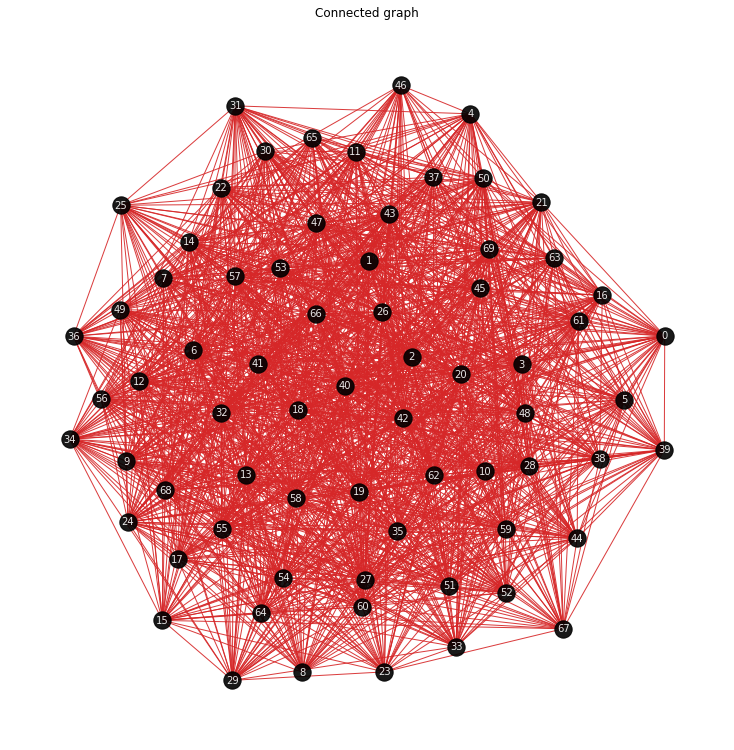

In [8]:
# Display graph
plt.figure(figsize=(10,10))
nx.draw(G.to_networkx(), nx.spring_layout(G.to_networkx(), seed=1), with_labels=True, 
        width=1, alpha=0.9, edge_color="tab:red",font_size=10, font_color="white",node_color="black")
plt.title('Connected graph' if G.is_connected() else 'Warning: unconnected graph')
#plt.savefig('I(70)-5,(9,2)-test.pdf', bbox_inches='tight',transparent=True)
plt.draw()

In [9]:
'''
k = 4;     K = tuplelist(range(k))    # Number of connected components
α = 9                                 # Minimum number of nodes per component
'''
K = tuplelist(range(k))               # Index of connected components
β = n - (k-1)*α                       # Maximum number of nodes per component
print('Created instance with (k,α,β) = ({0},{1},{2}).'.format(
    k,α,β)) if α <= floor(n/k) else warn('\n\n*** α is too big! ***\n\n')

Created instance with (k,α,β) = (9,2,54).


In [10]:
𝔸ᵏ = [n+i for i in K]
Vᵏ = V + 𝔸ᵏ
Eᵏ = [(i,j) for i in 𝔸ᵏ for j in V]

In [11]:
d = {a:G.es[G.get_eid(a[0],a[1])]['w'] for a in G.get_edgelist()}    # cost function
d.update({e: 0.0 for e in Eᵏ})

Eₒ = sorted(set(A))
E  = sorted( set(A).union(set(Eᵏ)) )                                  # Augmented graph
Aᶜ = G.complementer(loops=False).get_edgelist()
Eᶜ = sorted(set(Aᶜ))                                                 # Edges not in original graph
TE = E+[(j,i) for (i,j) in sorted(set(A))]                           # All edges from complete graph

In [12]:
# To improve numerics, we will divide the objective by
D = 1.0#/(2*k) #
D = 0.5 * sum(G.es['w']) / k

Compute $\mathsf{L}$ and check feasibility.

In [13]:
Shortest_Paths = pd.DataFrame(G.shortest_paths(weights=None))

In [14]:
Largest_SP = {i:j for (i,j) in Shortest_Paths.max(0).to_dict().items() if j >= β}

In [15]:
𝖫 = Largest_SP.keys()
q = len(𝖫)

In [16]:
if q > k:
    warn('\n\n*** Infeasibility check! Corollary 1. ***\n\n')
elif q > 0:
    print('There are',q,'nodes separated with a path with lenght greater than {0}.'.format(β))
else:
    print('No nodes are separated with a path with lenght greater than {0}.'.format(β))

No nodes are separated with a path with lenght greater than 54.


In [17]:
β_Shortest_Paths = {i:Shortest_Paths.where(Shortest_Paths>=β)[i].dropna().to_dict() for i in 𝖫}

In [18]:
#{i:{k:l for (k,l) in j.items() if l == True } for (i,j) in (Shortest_Paths >= β).to_dict().items()}
β_Shortest_Paths

{}

### Create model

In [19]:
if 'mo' in globals():        mo.dispose();    disposeDefaultEnv();    del mo

In [20]:
mo = Model()
x, x̄, y, f = tupledict(), tupledict(), tupledict(), tupledict()    # Dictionaries will contain variables

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-09


In [21]:
# *** Variables ***
# Link inside connected component #|x| = m + n*k
x = mo.addVars(E, vtype = 'B', name = 'x')
deque( (x[i,j].setAttr('obj', d[i,j]/D) for (i,j) in E), maxlen=0);    # Objective costs

# Indicator of connected component #|y| = n * k
y = mo.addVars(V, K, vtype = 'B', name = 'y')

# Flow on induced graph #|f| = 2*m + n*k
f = mo.addVars(TE, vtype = 'C', name = 'f')

In [22]:
mo.update()

In [23]:
# *** Constraints ***
# Each node must belong exactly to one cluster
mo.addConstrs((quicksum(y[i,c] for c in K) == 1 for i in V), name = 'R-2b-');
# If two nodes i,j ∈ V are assigned to Vₖ, then the edge {i,j} ∈ E belongs to the induced subgraph (Vₖ,E(Vₖ))
mo.addConstrs((y[i,c]+y[j,c]-x[i,j] <= 1.0  for (i,j) in Eₒ for c in K), name = 'R-2c-');
# Edges with end nodes in different connected components must be equal to zero
mo.addConstrs((y[i,c]+y[j,l]+x[i,j] <= 2.0 for (i,j) in Eₒ for c in K for l in K if c!=l), name = 'R-2d-');
# Only one artificial edge is active
mo.addConstrs((quicksum(x[i,j] for j in V) == 1.0 for i in 𝔸ᵏ), name = 'R-2e-');
# Flow will be sent through the active xᵢⱼ
mo.addConstrs((quicksum(f[i,j] - y[j,i-n] for j in V) == 0.0 for i in 𝔸ᵏ), name = 'R-2f-');
# Flow conservation
'''In_V  = {i:[(j,i) for j in G.neighbors(i)]+[(j,i) for j in Aᵏ] for i in V}
Out_V = {i:[(i,j) for j in G.neighbors(i)] for i in V}
mo.addConstrs((quicksum(f[i,j] for (i,j) in In_V[j]) - 
               quicksum(f[j,i] for (j,i) in Out_V[j]) == 1.0  for j in V), name = 'R-2i-g-');'''
FC = mo.addConstrs((quicksum(f[i,j] - f[j,i] for i in G.neighbors(j)) + 
                    quicksum(f[i,j] for i in Aᵏ) == 1.0  for j in V), name = 'R-2i-g-');

# Capacities for the antiparallel arcs associated to edge {i,j} ∈ E
mo.addConstrs((f[i,j] + f[j,i] <= β*x[i,j] for (i,j) in Eₒ), name = 'R-2h-');
# Min and max flow
mo.addConstrs((α * x[i,j] <= f[i,j] for (i,j) in Eᵏ), name = 'R-2i-a-');
mo.addConstrs((β * x[i,j] >= f[i,j] for (i,j) in Eᵏ), name = 'R-2i-b-');

In [24]:
# Lazy constraints for flow conservation 
#for a in FC.keys():    FC[a].Lazy = 1

### Valid inequalities

In [25]:
# LC [Th 2]
Leafs = [(i,G.neighbors(i)[0]) for i in V if G.degree(i) == 1]
Leafs = [e if e in E else e[::-1] for e in Leafs]
print(len([i for i in V if G.degree(i) == 1]),'leafs detected.')
#mo.addConstrs((x[i,j] == 1.0 for (i,j) in Leafs), name = 'VI-LC-a');
deque( (x[i,j].setAttr('lb', 1.0) for (i,j) in Leafs), maxlen=0);
deque( (f[i,j].setAttr('ub', 1.0) for (i,j) in Leafs), maxlen=0);
deque( (f[i,j].setAttr('lb', 1.0) for (i,j) in Leafs), maxlen=0);
deque( (f[j,i].setAttr('lb', 0.0) for (i,j) in Leafs), maxlen=0);
deque( (f[j,i].setAttr('ub', 0.0) for (i,j) in Leafs), maxlen=0);
#mo.addConstrs( (quicksum(y[i,c] + y[j,c] for c in K) == 2.0 for (i,j) in Leafs), name = 'VI-LC-c');

0 leafs detected.


In [26]:
# SCP [Th 3]
if len(β_Shortest_Paths) > 0:
    # We avoid adding the constraint twice
    Covered = []
    for (i,r) in β_Shortest_Paths.items():
        for j in r.keys():
            '''if ([i,j] in Covered) or ([j,i] in Covered):
                continue
            Covered.append([i,j])'''
            if {i,j} in Covered:
                continue
            else:
                Covered.append({i,j})
                mo.addConstrs( (y[i,c] + y[j,c] <= 1.0 for c in K), name = 'VI-SCP-'+str({i,j})+'-')

In [27]:
# LBC [Th 9]
mo.addConstr(quicksum(x[i,j] for (i,j) in E) >= n-k, name = 'VI-LBC');

### Optimization

In [28]:
mo.Params.TimeLimit = 60*60
mo.optimize()

Set parameter TimeLimit to value 3600
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 124419 rows, 6390 columns and 382800 nonzeros
Model fingerprint: 0xf5262d26
Variable types: 3630 continuous, 2760 integer (2760 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [2e-03, 2e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
Presolve time: 0.28s
Presolved: 124419 rows, 6390 columns, 382170 nonzeros
Variable types: 3630 continuous, 2760 integer (2760 binary)

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 1.107955e-01, 1758 iterations, 0.26 seconds (0.51 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.11080    0  403     

  5087  4708    0.11719    5  179          -    0.11506      -   648  551s
  5088  4712    0.11506   15  126          -    0.11506      -  30.1  559s
  5090  4715    0.11506   16  128          -    0.11506      -  30.6  562s
  5094  4722    0.11506   17  129          -    0.11506      -  31.7  566s
  5118  4738    0.11506   19  152          -    0.11506      -  39.0  570s
  5143  4757    0.11506   20  160          -    0.11506      -  46.7  575s
  5169  4786    0.11506   22  156          -    0.11506      -  52.3  625s
  5191  4836    0.11506   23  151          -    0.11506      -  56.6  632s
  5248  4964    0.11506   26  160          -    0.11506      -  71.5  652s
  5395  5164    0.11506   37  156          -    0.11506      -  93.9  685s
  5644  5504    0.11506   53  146          -    0.11506      -   132  730s
  6069  5652    0.11529   77  148          -    0.11506      -   180  785s
  6365  5823    0.13210  100  149          -    0.11506      -   241  852s
  6663  5974    0.15980  

In [38]:
mo.reset()
mo.Params.PreCrush = 1      # This one does not seem to be significantly different, though
mo.Params.Cuts = 0
mo.Params.Presolve = 0
mo.Params.TimeLimit = 3600.0 #60*60.0
mo.optimize()

Discarded solution information
Set parameter PreCrush to value 1
Set parameter Cuts to value 0
Set parameter Presolve to value 0
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 124419 rows, 6390 columns and 382800 nonzeros
Model fingerprint: 0xf5262d26
Variable types: 3630 continuous, 2760 integer (2760 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [2e-03, 2e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
Variable types: 3630 continuous, 2760 integer (2760 binary)

Root relaxation: objective 1.107955e-01, 3116 iterations, 0.25 seconds (0.59 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.11080    0  182          -    0.11080      -     -    1s
     0     0    

In [29]:
Vₖ = {c:[i for i in V if y[i,c].x>0.0] for c in K}
print(Vₖ)

{0: [0, 7, 13, 24, 31, 34, 39, 53], 1: [3, 30, 32, 41, 46, 64, 66], 2: [20, 37, 43, 48, 50, 58, 60], 3: [8, 15, 18, 19, 21, 26, 33, 47, 52], 4: [9, 12, 16, 25, 29, 56, 59, 67], 5: [10, 22, 27, 45, 49, 51, 54, 62], 6: [28, 35, 38, 55, 57, 65, 69], 7: [1, 4, 5, 6, 11, 17, 23, 44], 8: [2, 14, 36, 40, 42, 61, 63, 68]}


In [30]:
[G.induced_subgraph(Vₖ[c]).is_connected() for c in K]

[True, True, True, True, True, True, True, True, True]

In [31]:
{D*sum(x[i,j].obj for (i,j) in E if x[i,j].x > 0.0)}

{284.0000000000001}

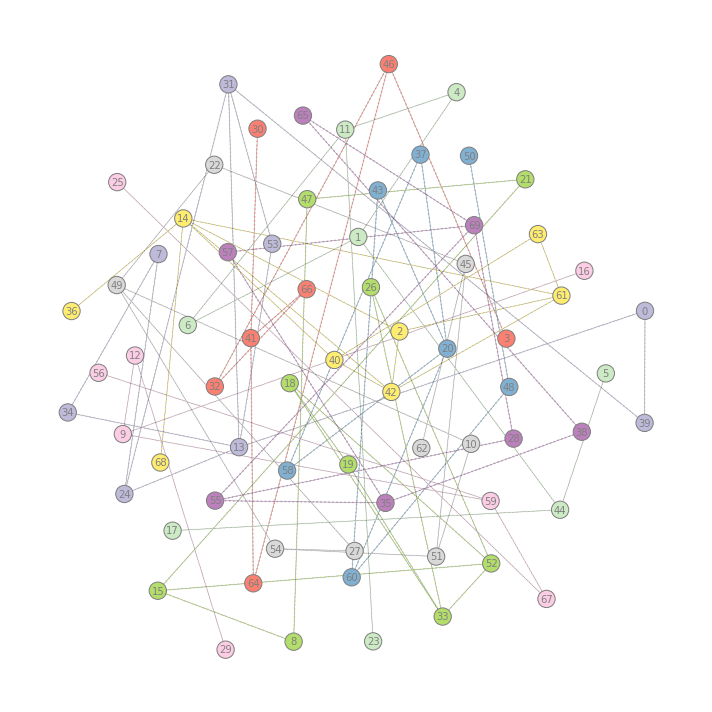

In [37]:
# Display graph with partitions
pos = nx.spring_layout(G.to_networkx(), seed=1)  # positions for all nodes
Col = cm.Set3(np.linspace(0.2, 1, k))

plt.figure(figsize=(10,10))
# Nodes
options = {"edgecolors": "tab:gray"}#, "node_size": 800, "alpha": 0.9}
for c in K:
    nx.draw_networkx_nodes(G.to_networkx(), pos, nodelist=Vₖ[c], node_color=[Col[c] for i in Vₖ[c]], **options)
    
# Edges
for c in K:
    pos_c = {i: pos[ Vₖ[c][i] ] for i in range(len(Vₖ[c]))}
    nx.draw_networkx_edges(G.induced_subgraph(Vₖ[c]).to_networkx(), pos_c, width=0.5, alpha=0.5)

    Eₖ = [e.tuple for e in G.induced_subgraph(Vₖ[c]).es ]#if e.tuple[0] not in Vₖ[c] and e.tuple[1] not in Vₖ[c]]
    nx.draw_networkx_edges(
        G.induced_subgraph(Vₖ[c]).to_networkx(), pos_c, edgelist=Eₖ, style=':',
        width=1.5, alpha=0.75,
        edge_color=[Col[c] for e in Eₖ],
    )
    
    
nx.draw_networkx_labels(G, pos, {i:i for i in G.vs.indices}, font_size=10, font_color="gray");
plt.tight_layout()
plt.axis("off")
#plt.savefig('I(70)-5,(9,2)-M2-VI.pdf', bbox_inches='tight',transparent=True)
plt.draw()

In [33]:
Data = pd.DataFrame.from_dict(
    {'Instance':[(n,m,k,α)],
     'z_R':[mo.ObjBound * D],'Obj': mo.objval * D,'gap': mo.MIPgap,'nodes':int(mo.nodecount), 'time':mo.RunTime})
display(Data)

,Instance,z_R,Obj,gap,nodes,time
0,"(73, 72, 4, 9)",365.0,380.0,0.039474,1461835,480.010154


In [34]:
name_out = 'Out[{0},{1},{2}]-M2-VI'.format(ins,k,α)

In [35]:
with pd.ExcelWriter(name_out + '.xlsx') as writer:  
    Data.to_excel(writer, sheet_name='Sheet_1')
    pd.DataFrame.from_dict(Vₖ, orient='index').fillna('').to_excel(writer, sheet_name='Sheet_2')

---